# Summary

Solve for a time-invariant or "steady-state" profile.

This is achieved by first integrating Hamilton's equations along an erosion ray trajectory initiated at a constant velocity "normal fault" boundary. Copies of this ray are then placed at uniformly spaced (vertically downwards) intervals along the boundary, generating a staggered time-sequence of rays whose ensemble positions at an appropriately chosen time slice constitute a time-invariant profile.

Visualization of the ray ensemble is carried out, along with graphing of properties of the time-invariant profile across the model domain. Comparison is made with the "steady-state" profile derived by integrating the model erosion equation directly (via a polynomial in $\mathrm{d}z/\mathrm{d}x$).

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():

#     pr_filenames = ['TimeInvariant_eta1p5_Ci0p1']
#     pr_filenames = ['TimeInvariant_eta1p5_Ci1']
#     pr_filenames = ['TimeInvariant_eta1p5_Ci4']
    
#     pr_filenames = ['TimeInvariant_eta0p5_Ci0p1']
#     pr_filenames = ['TimeInvariant_eta0p5_Ci1']
    pr_filenames = ['TimeInvariant_eta0p5_Ci4']

#     pr_filenames = ['TimeInvariant_eta0p25_Ci4']

else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging, sys
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import NumPy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
from sympy import simplify, Matrix, Eq, Rational, factor, poly, solve, numer, deg, N, \
                init_printing
# Set up latex inline printing
init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, convert, omitdict, gmround
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import eta, mu, Lc, Ci, varepsilon, varepsilonhat, beta_0,\
                             xiv_0, xih_0, h_0p9, th_0p9, h_0p95, th_0p95
from gme.core.equations import Equations
from gme.core.equations_subset import EquationSubset
from gme.core.utils import gradient_value
from gme.ode.time_invariant import TimeInvariantSolution
from gme.plot.ray_profiles import RayProfiles
from gme.plot.time_invariant import TimeInvariant

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme)
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Fetching working path from environment variable GME_WORKING_PATH = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['TimeInvariant_eta0p25_Ci4'])

In [4]:
from sympy import Symbol

In [5]:
type(eta)

sympy.core.symbol.Symbol

### Parameter parsing

In [6]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/defaults.json
gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/RayTracing/TimeInvariant_eta0p25_Ci4.json
gmplib.parameters.ParametersNestedGroup: p.job
gmplib.parameters.ParametersNestedGroup: p.model
gmplib.parameters.ParametersNestedGroup: p.solve
gmplib.parameters.ParametersNestedGroup: p.resolve
gmplib.parameters.ParametersNestedGroup: p.plot
gmplib.parameters.ParametersNestedGroup: p.save


{   'debug': False,
    'group_name': 'TimeInvariantSolutions',
    'short_name': 'tis',
    'subtitle': '',
    'title': 'Time-invariant profile solution: sin(beta), ramp, eta=1/4, '
             'mu=1/8, Ci=4deg',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/4,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/8,
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 10,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_order': 3,
    't

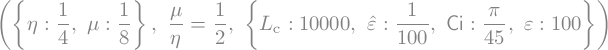

In [7]:
# Create a dict of the key physics parameters to be used in substitutions
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
    Ci: pr.model.Ci, 
    Lc: pr.model.Lc, 
    varepsilonhat: pr.model.varepsilonhat, 
    varepsilon: pr.model.varepsilonhat*pr.model.Lc
}
subexp, Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using SymPy) for a specific erosion model.

In [8]:
gmeq = Equations( parameters=sub,
                  eta_=pr.model.eta,
                  mu_=pr.model.mu, 
                  beta_type=pr.model.beta_type,
                  varphi_type=pr.model.varphi_type, 
                  do_raw=True )

gme.core.equations.Equations
gme.core.equations.EquationsMixedIn
gme.core.equations.EquationsBase
gme.core.rp.define_p_eqns
gme.core.rp.define_r_eqns
gme.core.xi.define_xi_eqns
gme.core.xi.define_xi_model_eqn
gme.core.xi.define_xi_related_eqns
gme.core.varphi.define_varphi_model_eqns
gme.core.varphi.define_varphi_related_eqns
gme.core.fundamental.define_Fstar_eqns
gme.core.fundamental.define_H_eqns
gme.core.hamiltons.define_rdot_eqns
gme.core.hamiltons.define_pdot_eqns
gme.core.hamiltons.define_Hamiltons_eqns
gme.core.ndim.nondimensionalize
gme.core.ndim.define_nodimensionalized_Hamiltons_eqns
gme.core.profile.define_z_eqns
gme.core.angles.define_tanalpha_eqns
gme.core.angles.define_tanbeta_eqns
gme.core.angles.define_psi_eqns
gme.core.metrictensor.define_g_eqns
gme.core.pxpoly.define_px_poly_eqn (ndim=False)
gme.core.pxpoly.define_px_poly_eqn (ndim=True)


# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Various ODE quadrature methods provided by SciPy's `solve_ivp` function can be used here:
"DOP853" (explicit Runge-Kutta method of order 8(5,3)  with dense output of order 7); basic Runge-Kutta (RK45 or RK23); "Radau" (implicit Runge-Kutta method of the Radau IIA family of order 5); "BDF" (implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation); "LSODA" (Adams/BDF method with automatic stiffness detection and switching). "Radau" is by far the most accurate (in terms of computing surface gradient); "DOP853" is less accurate, but its computation of vertical erosion rate is quite robust. "BDF" computes gradient a bit better, but its vertical erosion rate is less accurate. All quadrature methods have very similar timings.


Test timings and notes for `TimeInvariant_tanbeta_rampflat_eta1p0_xiv25_xh0p9`:
  - DOP853:  335ms
      - ~1% errors in relative gradient, minor error in vertical erosion rate
  - Radau:   340ms
      - better than ~0.1% errors in relative gradient, **robust** vertical erosion rate
  - RK45:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - RK23:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - BDF:   345ms
      - ~0.3% errors in relative gradient, moderate error in vertical erosion rate
  - LSODA:   335ms
      - ~1% errors in relative gradient, moderate error in vertical erosion rate

In [9]:
pr.model.beta_0 = float(beta_0.subs(e2d(gmeq.beta0_Ci_eqn
                                        .subs(omitdict(sub,[beta_0])).subs(subexp))))
sub.update({beta_0:pr.model.beta_0})
convert(Eq(beta_0, pr.model.beta_0), n=2, units=degrees, do_raw=False)

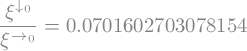

In [10]:
xivh0_ = float((xiv_0/xih_0).subs(e2d(gmeq.xiv0_xih0_Ci_eqn)).subs(sub).subs(subexp).n())
sub.update({(xiv_0/xih_0):xivh0_})
Eq(xiv_0/xih_0, sub[xiv_0/xih_0])

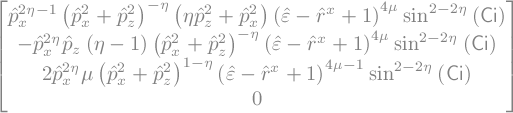

In [11]:
gmeq.hamiltons_ndim_eqns

gme.core.equations_subset.EquationSubset


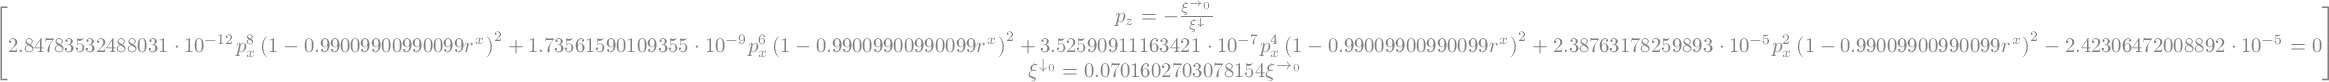

In [12]:
gmeq_ndim_subset = EquationSubset(gmeq, sub, do_ndim=True, do_revert=True) 
Matrix([
    gmeq_ndim_subset.pz_xiv_eqn,
    gmeq_ndim_subset.poly_px_xiv0_eqn,
    gmeq_ndim_subset.xiv0_xih0_Ci_eqn
])

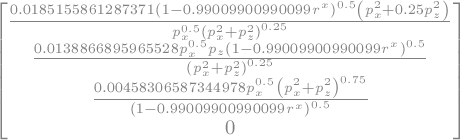

In [13]:
Matrix([gmeq_ndim_subset.hamiltons_eqns])

Create an instance of the ODE solution object.

In [14]:
pr.solve.choice, pr.solve.method[pr.solve.choice]

('Hamilton', 'DOP853')

In [15]:
xmax_ = 0.999 #float(1-varepsilonhat.subs(sub))

In [16]:
# reload(logging); logging.basicConfig(level=logging.INFO, format=f'%(message)s')

In [17]:
gmes = TimeInvariantSolution( gmeq_ndim_subset, parameters=sub, 
                              t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, 
                              x_stop=xmax_,
                              n_t=pr.solve.ray_n_t,
                              choice=pr.solve.choice, 
                              method=pr.solve.method[pr.solve.choice],
                              do_dense=pr.solve.do_dense )

gme.ode.base.BaseSolution.init:
   Solve Hamilton's ODEs using DOP853 method of integration


Set of initial conditions for the ray.

In [18]:
gmes.initial_conditions()

<class 'sympy.core.mul.Mul'>


Perform integration of the coupled ODEs.

In [19]:
gmes.solve()

gme.ode.base.BaseSolution.make_model:
   Constructing model Hamilton's equations


<class 'sympy.core.mul.Mul'>


In [20]:
soln = gmes.ivp_solns_list[0]
print(f'Number of ray-traced solutions: {len(gmes.ivp_solns_list)}\n\n'
      f'Message: {soln.message}\nSuccess? {soln.success}',
      f'\nStatus:{soln.status}\nt_final: {soln.t[-1]}\nrx_final: {soln.y[0][-1]}')

Number of ray-traced solutions: 1

Message: A termination event occurred.
Success? True 
Status:1
t_final: 9.152111111111113
rx_final: 0.9965492873078061


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [21]:
gmes.postprocessing(spline_order=pr.resolve.spline_order, extrapolation_mode=1)

gme.core.time_invariant.postprocessing


Generate a time-invariant profile by spatially integrating the topographic gradients implied by the time series of front normal slownesses  $\{\mathbf{\widetilde{p}}\}$. 

This profile can alternatively be generated by synthesizing a staggered sequence of rays and gathering all the ray positions $\{\mathbf{r}\}$ for a chosen time slice. This has already been done in the post-processing step.

In [22]:
gmes.integrate_h_profile(do_truncate=True, x_max=1) #xmax_

gme.core.time_invariant.integrate_h_profile


In [23]:
# t_0p95 = symbols(r't^{\rightarrow_{0.95}}',  real=True, negative=False)
# h_0p95 = symbols(r'h_{0.95}',  real=True, negative=False)
# t_0p9 = symbols(r't^{\rightarrow_{0.9}}',  real=True, negative=False)
# h_0p9 = symbols(r'h_{0.9}',  real=True, negative=False)

# Results

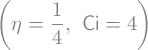

In [24]:
Eq(eta,pr.model.eta), Eq(Ci,deg(pr.model.Ci))

In [25]:
x_ = 0.9
Eq(h_0p9, gmes.h_interp(x_)), Eq(th_0p9, gmes.t_interp_x(x_))

In [26]:
x_ = 0.95
Eq(h_0p95, gmes.h_interp(x_)), Eq(th_0p95, gmes.t_interp_x(x_))

# Plots

## Preliminaries

In [27]:
gr_ray = RayProfiles()
gr_tis = TimeInvariant()

In [28]:
prefix = pr.job.short_name

suffix  = f'_eta{float(N(pr.model.eta))}'
suffix += f'_Ci{float(N(deg(pr.model.Ci)))}'
# suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' if gmeq.mu!=Rational(1,2) else ''
# suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}')

job_name = prefix+suffix.replace('.','p')
job_name

'tis_eta0p25_Ci4p0'

## Graphs

Graph a selection of staggered ray solutions (colorized lines with arrows) along with the time-invariant solution solved for in two ways (gathering of staggered ray termini or integration of gradients along a ray).

gmplib.plot.GraphingBase:
   Creating plot: tis_eta0p25_Ci4p0_h_rays size=(10, 7) @ 100 dpi


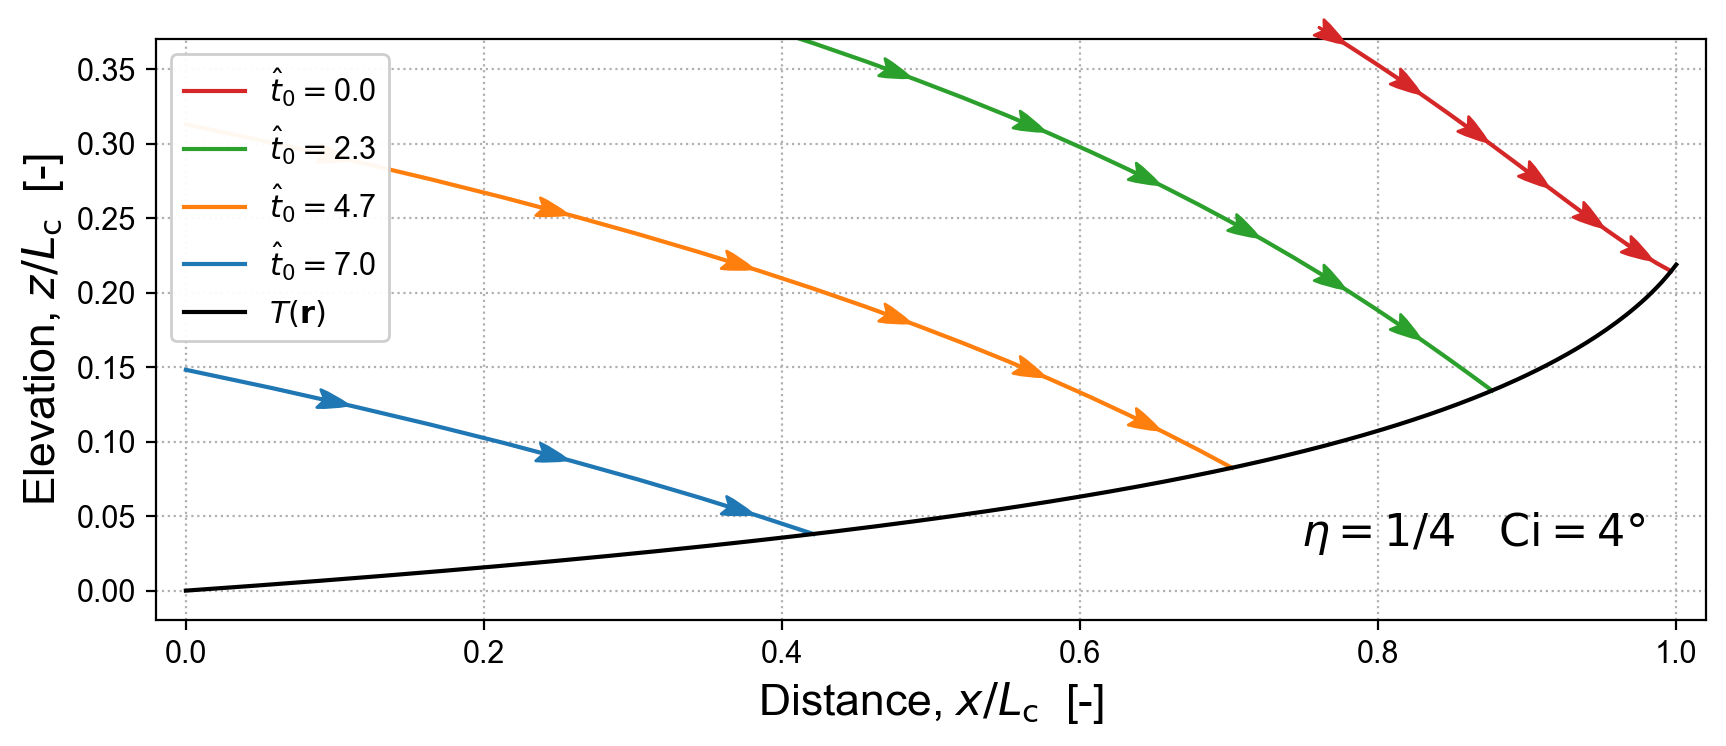

In [29]:
gr_ray.profile_h_rays( gmes, gmeq, sub, job_name+'_h_rays', fig_size=(10,7), 
                       x_limits=pr.plot.ray_x_limits, 
                       y_limits=pr.plot.ray_y_limits, 
                       eta_label_xy=pr.plot.ray_eta_xy, 
                       n_points=pr.plot.rays_n_points,
                       n_rays=pr.plot.n_rays,
                       do_pub_label=pr.plot.do_pub_labeling, 
                       pub_label=pr.plot.pub_labels['profile_h_rays'],
                       pub_label_xy=pr.plot.pub_label_posns['profile_h_rays'] )

Graph the behavior of $\mathbf{r}$, $\mathbf{v}$, and  $\mathbf{\widetilde{p}}$ along a time-invariant profile, along with a measure of $\mathbf{v},\mathbf{\widetilde{p}}$ anisotropy.

gmplib.plot.GraphingBase:
   Creating plot: tis_eta0p25_Ci4p0_aniso size=(10, 7) @ 100 dpi


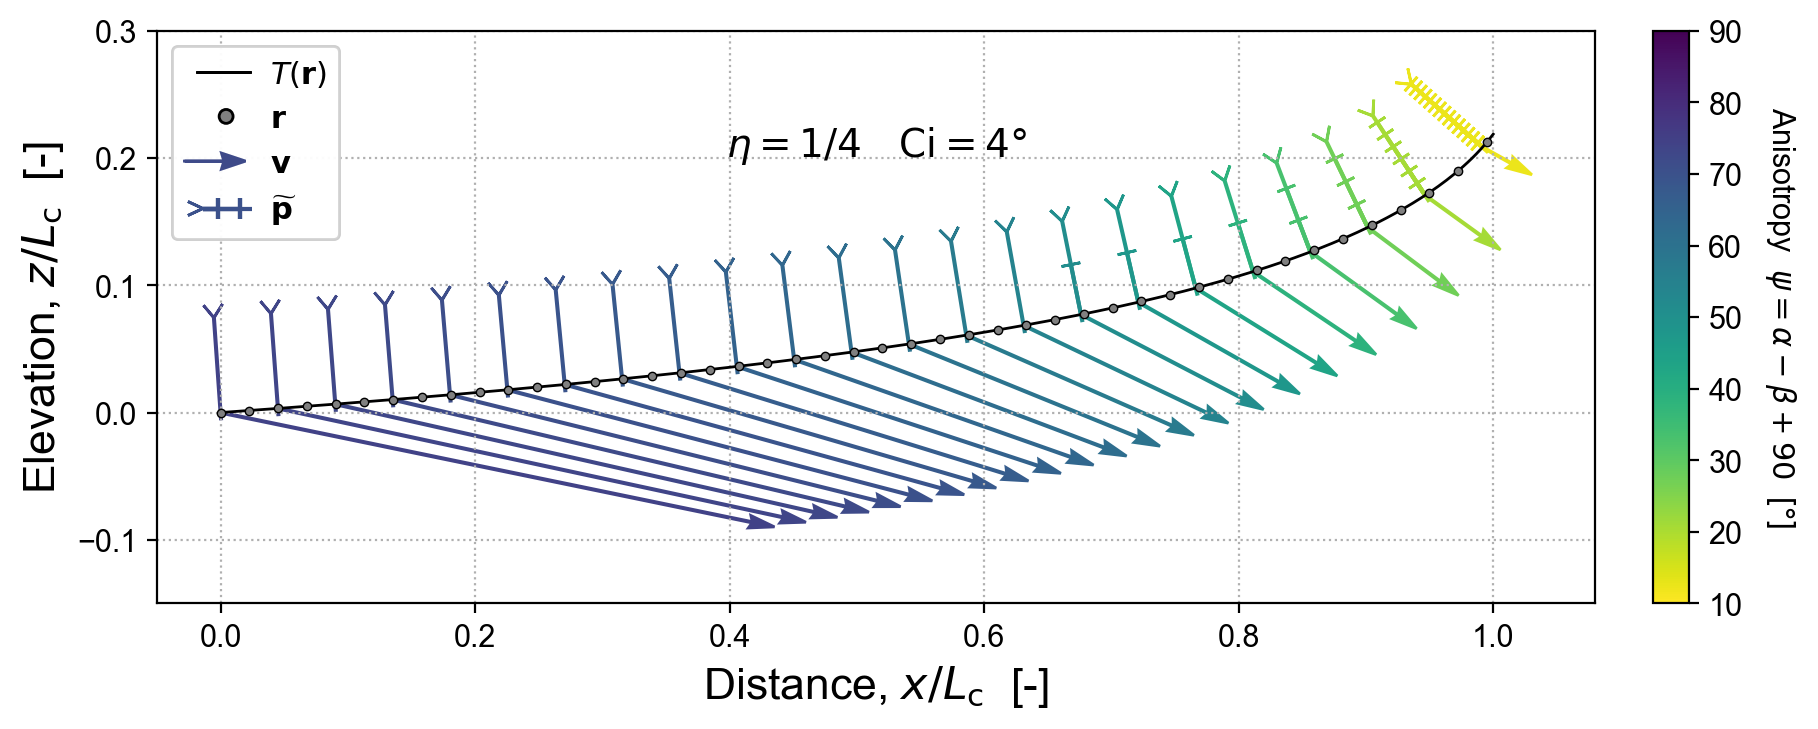

In [30]:
gr_tis.profile_aniso( gmes, gmeq, sub, job_name+'_aniso', fig_size=(10,7), 
                  y_limits=pr.plot.aniso_y_limits, 
                  xf_stop=0.995,
                  n_points=pr.plot.aniso_n_points, n_arrows=(pr.plot.aniso_n_points+1)//2, 
                  do_pub_label=pr.plot.do_pub_labeling, 
                  pub_label=pr.plot.pub_labels['profile_aniso'])

gmplib.plot.GraphingBase:
   Creating plot: tis_eta0p25_Ci4p0_beta size=(8, 3) @ 100 dpi


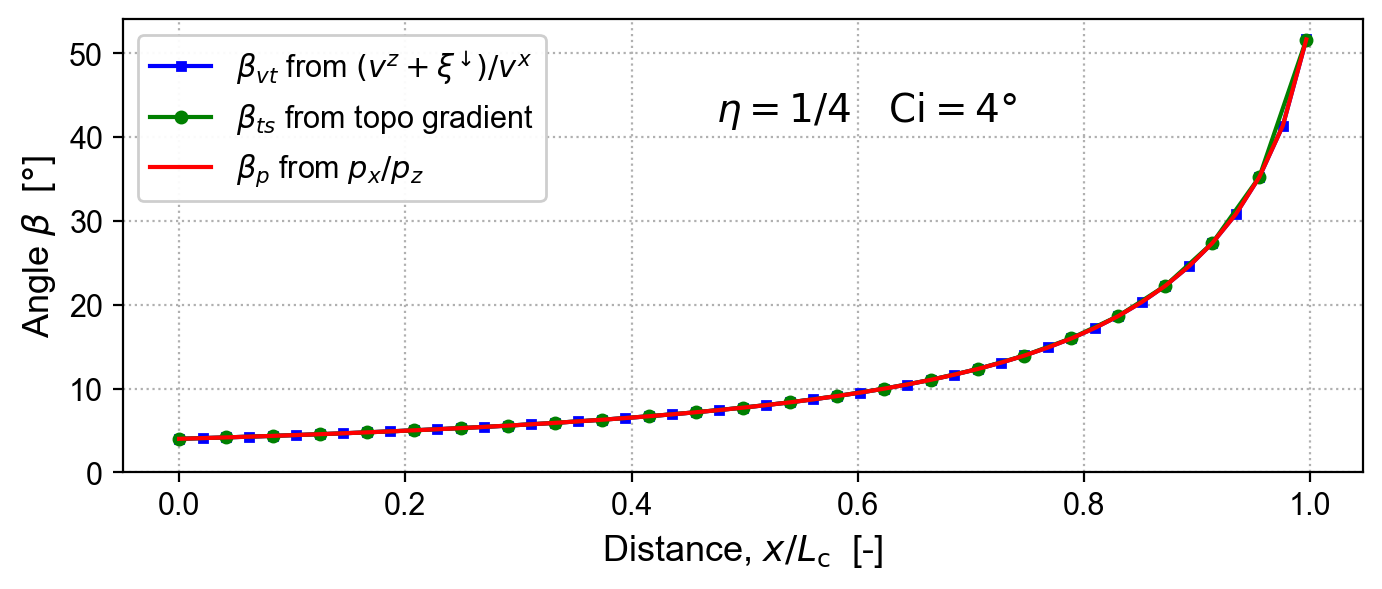

In [31]:
gr_tis.profile_beta( gmes, gmeq, sub, job_name+'_beta', fig_size=(8,3), n_points=25,
                 do_pub_label=pr.plot.do_pub_labeling, 
                 pub_label=pr.plot.pub_labels['profile_beta'],
                 pub_label_xy=pr.plot.pub_label_posns['profile_beta'] )

gmplib.plot.GraphingBase:
   Creating plot: tis_eta0p25_Ci4p0_beta_error size=(8, 3) @ 100 dpi


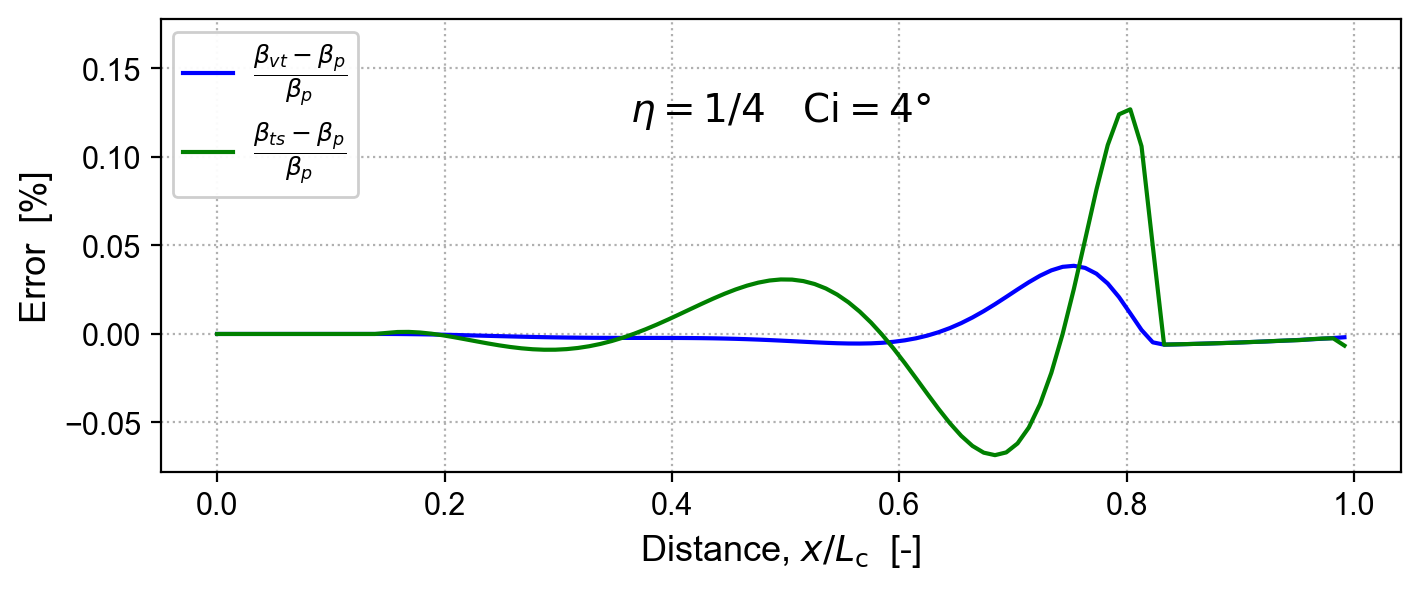

In [32]:
gr_tis.profile_beta_error( gmes, gmeq, sub, job_name+'_beta_error', fig_size=(8,3), 
                       n_points=pr.plot.profile_n_points )

gmplib.plot.GraphingBase:
   Creating plot: tis_eta0p25_Ci4p0_xi size=(8, 3) @ 100 dpi
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituti

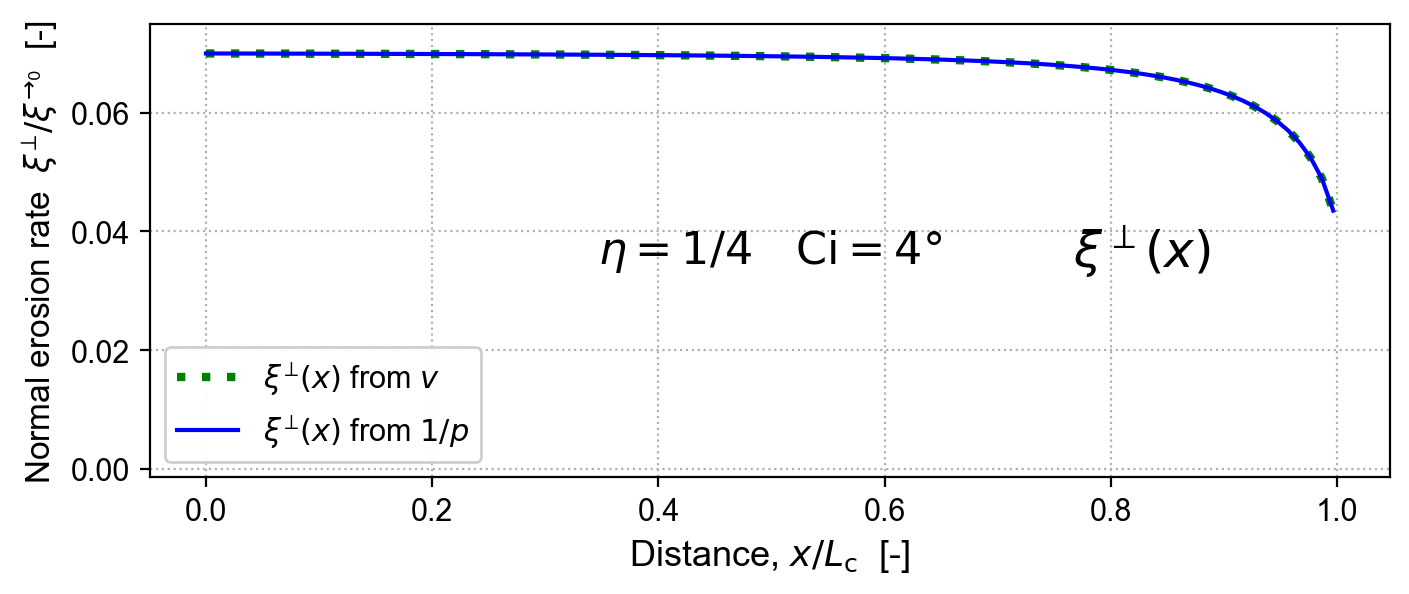

In [33]:
gr_tis.profile_xi( gmes, gmeq, sub, job_name+'_xi', fig_size=(8,3), 
               n_points=pr.plot.profile_n_points, 
               xi_norm=1, #xih_0.subs(sub), 
               do_etaxi_label=pr.plot.do_etaxi_labeling,
               do_pub_label=pr.plot.do_pub_labeling,
               pub_label=pr.plot.pub_labels['profile_xi'] )

gmplib.plot.GraphingBase:
   Creating plot: tis_eta0p25_Ci4p0_xihorizontal size=(8, 3) @ 100 dpi


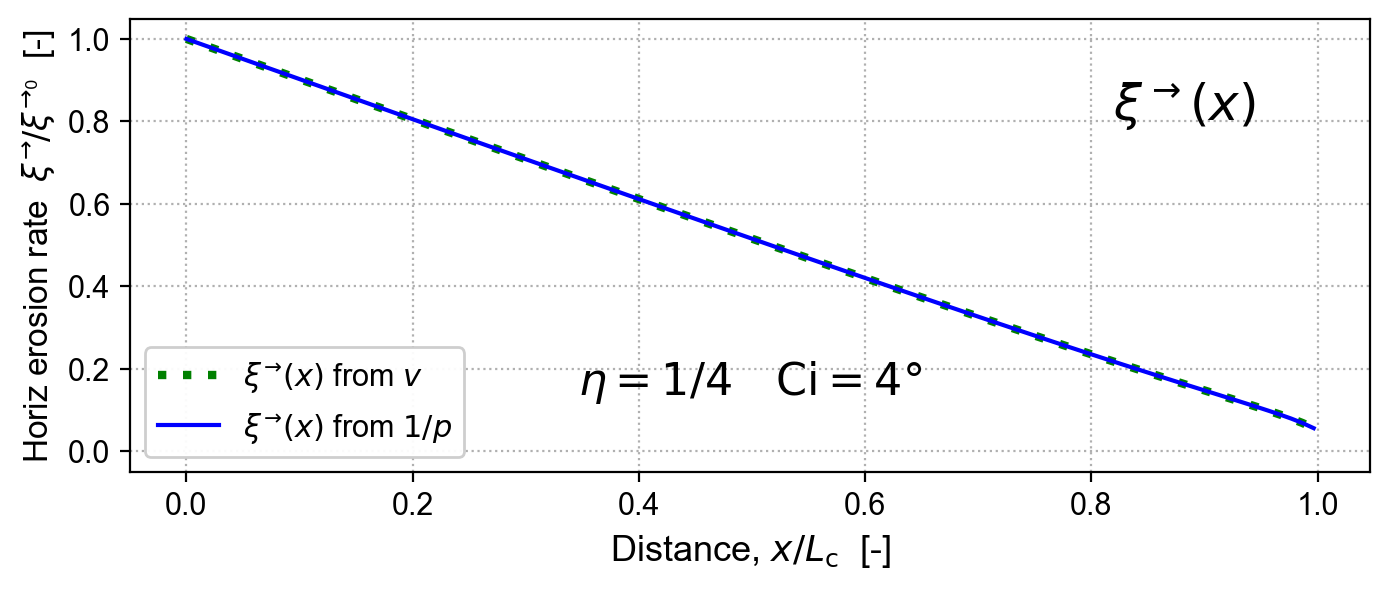

In [34]:
gr_tis.profile_xihorizontal( gmes, gmeq, sub, job_name+'_xihorizontal', fig_size=(8,3), 
                         n_points=pr.plot.profile_n_points, 
                         xi_norm=1, #xih_0.subs(sub), 
                         do_etaxi_label=pr.plot.do_etaxi_labeling,
                         do_pub_label=pr.plot.do_pub_labeling,
                         pub_label=pr.plot.pub_labels['profile_xihorizontal'] )

gmplib.plot.GraphingBase:
   Creating plot: tis_eta0p25_Ci4p0_xivertical size=(8, 3) @ 100 dpi


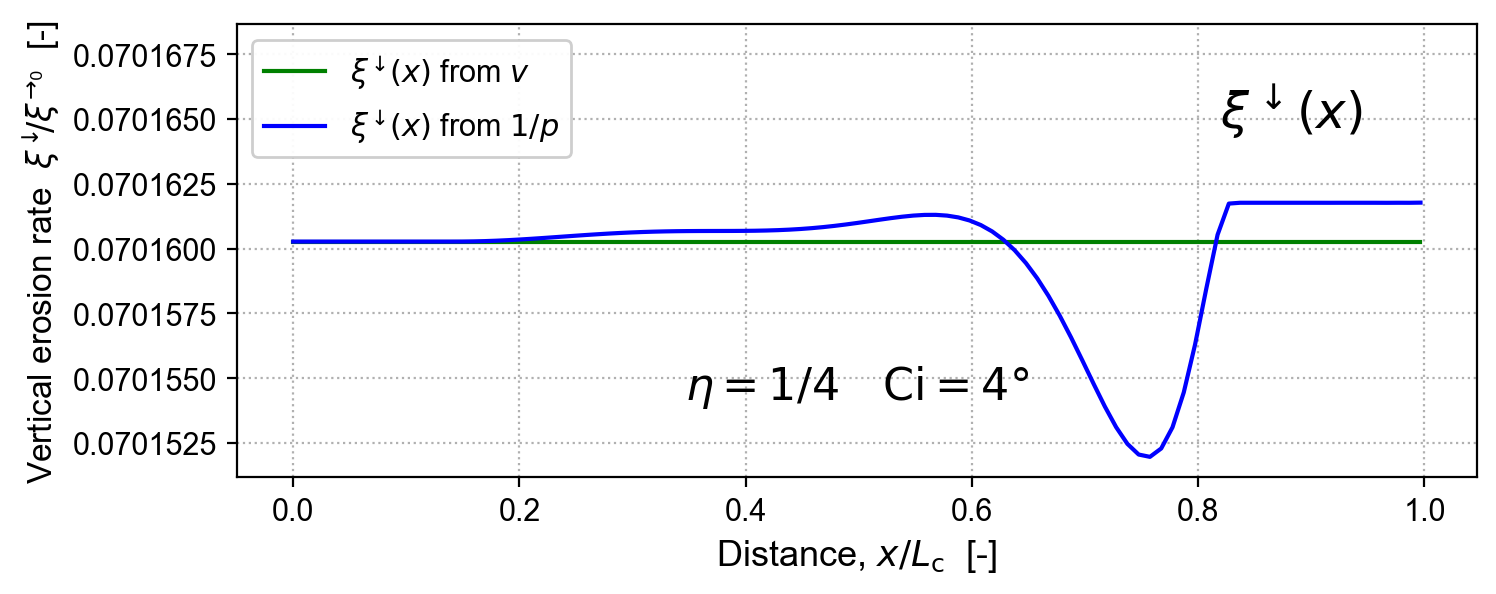

In [35]:
gr_tis.profile_xivertical( gmes, gmeq, sub, job_name+'_xivertical', fig_size=(8,3), 
                       n_points=pr.plot.profile_n_points, 
                       xi_norm=1, #xih_0.subs(sub), 
                       do_etaxi_label=pr.plot.do_etaxi_labeling,
                       do_pub_label=pr.plot.do_pub_labeling, 
                       pub_label=pr.plot.pub_labels['profile_xivertical'] )

# Save

Export the graphs as PNG and/or PDF image files.

In [36]:
gr_list = [gr_ray, gr_tis]
for gr_ in gr_list: pp( gr_.fdict )

{'tis_eta0p25_Ci4p0_h_rays': <Figure size 1000x700 with 1 Axes>}
{   'tis_eta0p25_Ci4p0_aniso': <Figure size 1000x700 with 2 Axes>,
    'tis_eta0p25_Ci4p0_beta': <Figure size 800x300 with 1 Axes>,
    'tis_eta0p25_Ci4p0_beta_error': <Figure size 800x300 with 1 Axes>,
    'tis_eta0p25_Ci4p0_xi': <Figure size 800x300 with 1 Axes>,
    'tis_eta0p25_Ci4p0_xihorizontal': <Figure size 800x300 with 1 Axes>,
    'tis_eta0p25_Ci4p0_xivertical': <Figure size 800x300 with 1 Axes>}


In [37]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
for gr_ in gr_list:
    export_plots( gr_.fdict, plots_dir, 
                  file_types=pr.save.figs_format, 
                  dpi=pr.save.figs_options['dpi'] )

gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/TimeInvariantSolutions"
gmplib.save.export_plot: Exported "tis_eta0p25_Ci4p0_h_rays.jpg"
gmplib.save.export_plot: Exported "tis_eta0p25_Ci4p0_h_rays.pdf"
gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/TimeInvariantSolutions"
gmplib.save.export_plot: Exported "tis_eta0p25_Ci4p0_aniso.jpg"
gmplib.save.export_plot: Exported "tis_eta0p25_Ci4p0_beta.jpg"
gmplib.save.export_plot: Exported "tis_eta0p25_Ci4p0_beta_error.jpg"
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from STIXGeneral
Substituting symbol \perp from